In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Funcs

In [2]:

def generate_ibm_hr_dataset(n_samples=1_000_000, seed=42):
    """
    Gera um dataset sintético inspirado no IBM HR Analytics com relações mais realistas

    Parameters:
    n_samples (int): Número de amostras a gerar
    seed (int): Seed para reprodutibilidade

    Returns:
    pd.DataFrame: Dataset gerado
    """
    np.random.seed(seed)

    # Gerando dados base
    data = {}

    # Idade com distribuição mais realista (concentrada entre 25-50 anos)
    data['Age'] = np.random.normal(38, 10, n_samples).astype(int)
    data['Age'] = np.clip(data['Age'], 18, 65)

    # Gênero
    data['Gender'] = np.random.choice(['Female', 'Male'], n_samples, p=[0.4, 0.6])

    # Educação (1-5: Below College, College, Bachelor, Master, Doctor)
    education_probs = [0.05, 0.15, 0.40, 0.30, 0.10]
    data['Education'] = np.random.choice([1, 2, 3, 4, 5], n_samples, p=education_probs)

    # Campo educacional baseado no nível de educação
    education_fields = ['Life Sciences', 'Other', 'Medical', 'Marketing', 'Technical Degree', 'Human Resources']
    data['EducationField'] = np.random.choice(education_fields, n_samples)

    # Departamento
    dept_probs = [0.45, 0.40, 0.15]  # Sales mais comum, HR menos comum
    data['Department'] = np.random.choice(['Sales', 'Research & Development', 'Human Resources'],
                                        n_samples, p=dept_probs)

    # Job Role baseado no departamento
    job_roles = {
        'Sales': ['Sales Executive', 'Sales Representative', 'Manager'],
        'Research & Development': ['Research Scientist', 'Laboratory Technician', 'Research Director', 'Manager'],
        'Human Resources': ['Human Resources', 'Manager']
    }

    data['JobRole'] = np.empty(n_samples, dtype=object)
    for dept in job_roles:
        mask = np.array(data['Department']) == dept
        n_dept = mask.sum()
        if n_dept > 0:
            data['JobRole'][mask] = np.random.choice(job_roles[dept], n_dept)

    # Job Level correlacionado com idade e educação
    base_level = np.ones(n_samples)
    age_bonus = (np.array(data['Age']) - 18) / 47 * 2  # 0-2 pontos baseado na idade
    edu_bonus = (np.array(data['Education']) - 1) / 4 * 2  # 0-2 pontos baseado na educação

    data['JobLevel'] = np.round(base_level + age_bonus + edu_bonus).astype(int)
    data['JobLevel'] = np.clip(data['JobLevel'], 1, 5)

    # Total Working Years correlacionado com idade
    data['TotalWorkingYears'] = np.maximum(0, data['Age'] - 18 - np.random.randint(0, 5, n_samples))

    # Years at Company (não pode ser maior que TotalWorkingYears)
    data['YearsAtCompany'] = np.random.randint(0, 21, n_samples)
    data['YearsAtCompany'] = np.minimum(data['YearsAtCompany'], data['TotalWorkingYears'])

    # Years in Current Role (não pode ser maior que YearsAtCompany)
    data['YearsInCurrentRole'] = np.random.randint(0, 11, n_samples)
    data['YearsInCurrentRole'] = np.minimum(data['YearsInCurrentRole'], data['YearsAtCompany'])

    # Years Since Last Promotion
    data['YearsSinceLastPromotion'] = np.random.randint(0, 8, n_samples)
    data['YearsSinceLastPromotion'] = np.minimum(data['YearsSinceLastPromotion'], data['YearsAtCompany'])

    # Years With Current Manager
    data['YearsWithCurrManager'] = np.random.randint(0, 8, n_samples)
    data['YearsWithCurrManager'] = np.minimum(data['YearsWithCurrManager'], data['YearsInCurrentRole'])

    # Número de empresas trabalhadas (correlacionado com anos totais de trabalho)
    max_companies = np.minimum(data['TotalWorkingYears'] // 2, 9)
    data['NumCompaniesWorked'] = np.array([np.random.randint(0, max(1, mc) + 1) for mc in max_companies])

    # Monthly Income correlacionado com JobLevel, Education e TotalWorkingYears
    base_income = 2000
    level_factor = data['JobLevel'] * 2000
    education_factor = data['Education'] * 500
    experience_factor = data['TotalWorkingYears'] * 100
    noise = np.random.normal(0, 1000, n_samples)

    data['MonthlyIncome'] = base_income + level_factor + education_factor + experience_factor + noise
    data['MonthlyIncome'] = np.clip(data['MonthlyIncome'].astype(int), 1000, 20000)

    # Rates
    data['DailyRate'] = np.random.randint(100, 1500, n_samples)
    data['HourlyRate'] = np.random.randint(30, 100, n_samples)
    data['MonthlyRate'] = np.random.randint(2000, 27000, n_samples)

    # Distance from home (distribuição exponencial - mais pessoas moram perto)
    data['DistanceFromHome'] = np.random.exponential(7, n_samples).astype(int) + 1
    data['DistanceFromHome'] = np.clip(data['DistanceFromHome'], 1, 29)

    # Business Travel
    travel_probs = [0.70, 0.20, 0.10]  # Maioria viaja raramente
    data['BusinessTravel'] = np.random.choice(['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'],
                                            n_samples, p=travel_probs)

    # Satisfação e envolvimento
    data['EnvironmentSatisfaction'] = np.random.choice([1, 2, 3, 4], n_samples, p=[0.10, 0.20, 0.40, 0.30])
    data['JobSatisfaction'] = np.random.choice([1, 2, 3, 4], n_samples, p=[0.10, 0.20, 0.40, 0.30])
    data['RelationshipSatisfaction'] = np.random.choice([1, 2, 3, 4], n_samples, p=[0.10, 0.20, 0.40, 0.30])
    data['JobInvolvement'] = np.random.choice([1, 2, 3, 4], n_samples, p=[0.05, 0.15, 0.50, 0.30])
    data['WorkLifeBalance'] = np.random.choice([1, 2, 3, 4], n_samples, p=[0.10, 0.25, 0.45, 0.20])

    # Performance Rating (maioria boa performance)
    data['PerformanceRating'] = np.random.choice([3, 4], n_samples, p=[0.84, 0.16])

    # Percent Salary Hike correlacionado com Performance Rating
    data['PercentSalaryHike'] = np.where(
        data['PerformanceRating'] == 4,
        np.random.randint(15, 26, n_samples),
        np.random.randint(11, 18, n_samples)
    )

    # Stock Option Level correlacionado com JobLevel
    data['StockOptionLevel'] = np.random.choice([0, 1, 2, 3], n_samples,
                                               p=[0.40, 0.35, 0.20, 0.05])
    high_level_mask = data['JobLevel'] >= 4
    data['StockOptionLevel'][high_level_mask] = np.random.choice([1, 2, 3],
                                                                 high_level_mask.sum(),
                                                                 p=[0.30, 0.50, 0.20])

    # Training Times Last Year
    data['TrainingTimesLastYear'] = np.random.choice([0, 1, 2, 3, 4, 5, 6], n_samples,
                                                    p=[0.05, 0.10, 0.25, 0.30, 0.20, 0.08, 0.02])

    # Marital Status
    data['MaritalStatus'] = np.random.choice(['Single', 'Married', 'Divorced'], n_samples,
                                           p=[0.32, 0.55, 0.13])

    # OverTime - maior probabilidade para níveis menores e pessoas mais jovens
    overtime_base_prob = 0.28
    age_factor = (65 - data['Age']) / 47 * 0.1  # Jovens trabalham mais overtime
    level_factor = (5 - data['JobLevel']) / 4 * 0.1  # Níveis menores trabalham mais overtime

    overtime_prob = np.clip(overtime_base_prob + age_factor + level_factor, 0.1, 0.5)
    data['OverTime'] = [np.random.choice(['Yes', 'No'], p=[p, 1-p]) for p in overtime_prob]

    # Attrition - baseado em múltiplos fatores
    attrition_score = np.zeros(n_samples)

    # Fatores que aumentam attrition
    attrition_score += (data['JobSatisfaction'] == 1) * 0.15
    attrition_score += (data['EnvironmentSatisfaction'] == 1) * 0.10
    attrition_score += (data['WorkLifeBalance'] == 1) * 0.10
    attrition_score += (np.array(data['OverTime']) == 'Yes') * 0.08
    attrition_score += (data['YearsSinceLastPromotion'] > 5) * 0.05
    attrition_score += (data['DistanceFromHome'] > 20) * 0.05
    attrition_score += (np.array(data['MaritalStatus']) == 'Single') * 0.03
    attrition_score += (data['NumCompaniesWorked'] > 5) * 0.04

    # Fatores que diminuem attrition
    attrition_score -= (data['JobLevel'] >= 4) * 0.10
    attrition_score -= (data['YearsAtCompany'] > 10) * 0.08
    attrition_score -= (data['StockOptionLevel'] > 0) * 0.05

    # Probabilidade base de 16%
    attrition_prob = np.clip(0.16 + attrition_score, 0.05, 0.50)
    data['Attrition'] = [np.random.choice(['Yes', 'No'], p=[p, 1-p]) for p in attrition_prob]

    # Campos fixos
    data['EmployeeCount'] = np.ones(n_samples, dtype=int)
    data['EmployeeNumber'] = np.arange(1, n_samples + 1)
    data['Over18'] = ['Y'] * n_samples
    data['StandardHours'] = [80] * n_samples

    # Criar DataFrame
    df = pd.DataFrame(data)

    # Reordenar colunas para match com o dataset original
    column_order = [
        'Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
        'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
        'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
        'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
        'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
        'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
        'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
        'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
        'YearsWithCurrManager'
    ]

    return df[column_order]

# Basico

In [3]:
df = generate_ibm_hr_dataset(n_samples=1_000_000, seed=42)

In [4]:
df.to_csv('../data/ibm_hr_dataset.csv', index=False)

## Exibir as primeiras linhas do dataset


In [4]:
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,42,No,Travel_Rarely,575,Research & Development,1,3,Marketing,1,1,...,2,80,1,24,3,4,5,0,3,0
1,36,No,Travel_Rarely,535,Human Resources,2,4,Human Resources,1,2,...,4,80,1,18,5,2,17,8,7,3
2,44,No,Travel_Rarely,286,Research & Development,2,4,Medical,1,3,...,1,80,2,22,3,3,20,0,1,0
3,53,Yes,Travel_Frequently,746,Sales,11,2,Medical,1,4,...,4,80,0,31,1,3,3,3,0,3
4,35,No,Travel_Rarely,408,Research & Development,7,5,Technical Degree,1,5,...,2,80,1,17,2,1,14,5,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,42,No,Travel_Rarely,262,Research & Development,10,4,Life Sciences,1,999996,...,4,80,1,20,3,4,6,4,6,4
999996,39,Yes,Travel_Rarely,340,Sales,20,3,Life Sciences,1,999997,...,4,80,1,18,6,3,14,10,2,3
999997,36,No,Travel_Frequently,777,Sales,15,4,Marketing,1,999998,...,4,80,2,16,4,4,9,2,6,1
999998,52,Yes,Travel_Rarely,1148,Human Resources,2,3,Human Resources,1,999999,...,2,80,1,31,4,1,18,0,4,0


## Exibir estatísticas descritivas do dataset

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000000.0,37.573109,9.752131,18.0,31.00,37.0,44.00,65.0
DailyRate,1000000.0,800.110722,404.135932,100.0,451.00,800.0,1150.00,1499.0
DistanceFromHome,1000000.0,7.389395,6.487020,1.0,3.00,5.0,10.00,29.0
Education,1000000.0,3.250821,0.993399,1.0,3.00,3.0,4.00,5.0
EmployeeCount,1000000.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EmployeeNumber,1000000.0,500000.500000,288675.278932,1.0,250000.75,500000.5,750000.25,1000000.0
EnvironmentSatisfaction,1000000.0,2.898258,0.944161,1.0,2.00,3.0,4.00,4.0
HourlyRate,1000000.0,64.528856,20.204914,30.0,47.00,65.0,82.00,99.0
JobInvolvement,1000000.0,3.050033,0.803532,1.0,3.00,3.0,4.00,4.0
JobLevel,1000000.0,2.960664,0.700052,1.0,3.00,3.0,3.00,5.0


In [6]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.0,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,37.573109,800.110722,7.389395,3.250821,1.0,500000.500000,2.898258,64.528856,3.050033,2.960664,...,2.900015,80.0,1.104926,17.646932,2.818794,2.750494,8.291746,3.712092,2.792037,2.084859
std,9.752131,404.135932,6.487020,0.993399,0.0,288675.278932,0.944161,20.204914,0.803532,0.700052,...,0.942661,0.0,0.943522,9.711037,1.328194,0.886850,5.723518,2.980426,2.236920,1.952559
min,18.000000,100.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,451.000000,3.000000,3.000000,1.0,250000.750000,2.000000,47.000000,3.000000,3.000000,...,2.000000,80.0,0.000000,11.000000,2.000000,2.000000,3.000000,1.000000,1.000000,0.000000
50%,37.000000,800.000000,5.000000,3.000000,1.0,500000.500000,3.000000,65.000000,3.000000,3.000000,...,3.000000,80.0,1.000000,17.000000,3.000000,3.000000,8.000000,3.000000,2.000000,2.000000
75%,44.000000,1150.000000,10.000000,4.000000,1.0,750000.250000,4.000000,82.000000,4.000000,3.000000,...,4.000000,80.0,2.000000,24.000000,4.000000,3.000000,13.000000,6.000000,5.000000,3.000000
max,65.000000,1499.000000,29.000000,5.000000,1.0,1000000.000000,4.000000,99.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,47.000000,6.000000,4.000000,20.000000,10.000000,7.000000,7.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 35 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   Age                       1000000 non-null  int64 
 1   Attrition                 1000000 non-null  object
 2   BusinessTravel            1000000 non-null  object
 3   DailyRate                 1000000 non-null  int64 
 4   Department                1000000 non-null  object
 5   DistanceFromHome          1000000 non-null  int64 
 6   Education                 1000000 non-null  int64 
 7   EducationField            1000000 non-null  object
 8   EmployeeCount             1000000 non-null  int64 
 9   EmployeeNumber            1000000 non-null  int64 
 10  EnvironmentSatisfaction   1000000 non-null  int64 
 11  Gender                    1000000 non-null  object
 12  HourlyRate                1000000 non-null  int64 
 13  JobInvolvement            1000000 non-null 

## Exibir a distribuição da variável alvo

In [8]:
df['Attrition'].value_counts(normalize=True)

Attrition
No     0.821159
Yes    0.178841
Name: proportion, dtype: float64

# EDA

## Correlação

### Var numericas

In [9]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
print(f"=== VARIÁVEIS NUMÉRICAS ({len(numeric_cols)}) ===")
print(numeric_cols.tolist())

=== VARIÁVEIS NUMÉRICAS (26) ===
['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


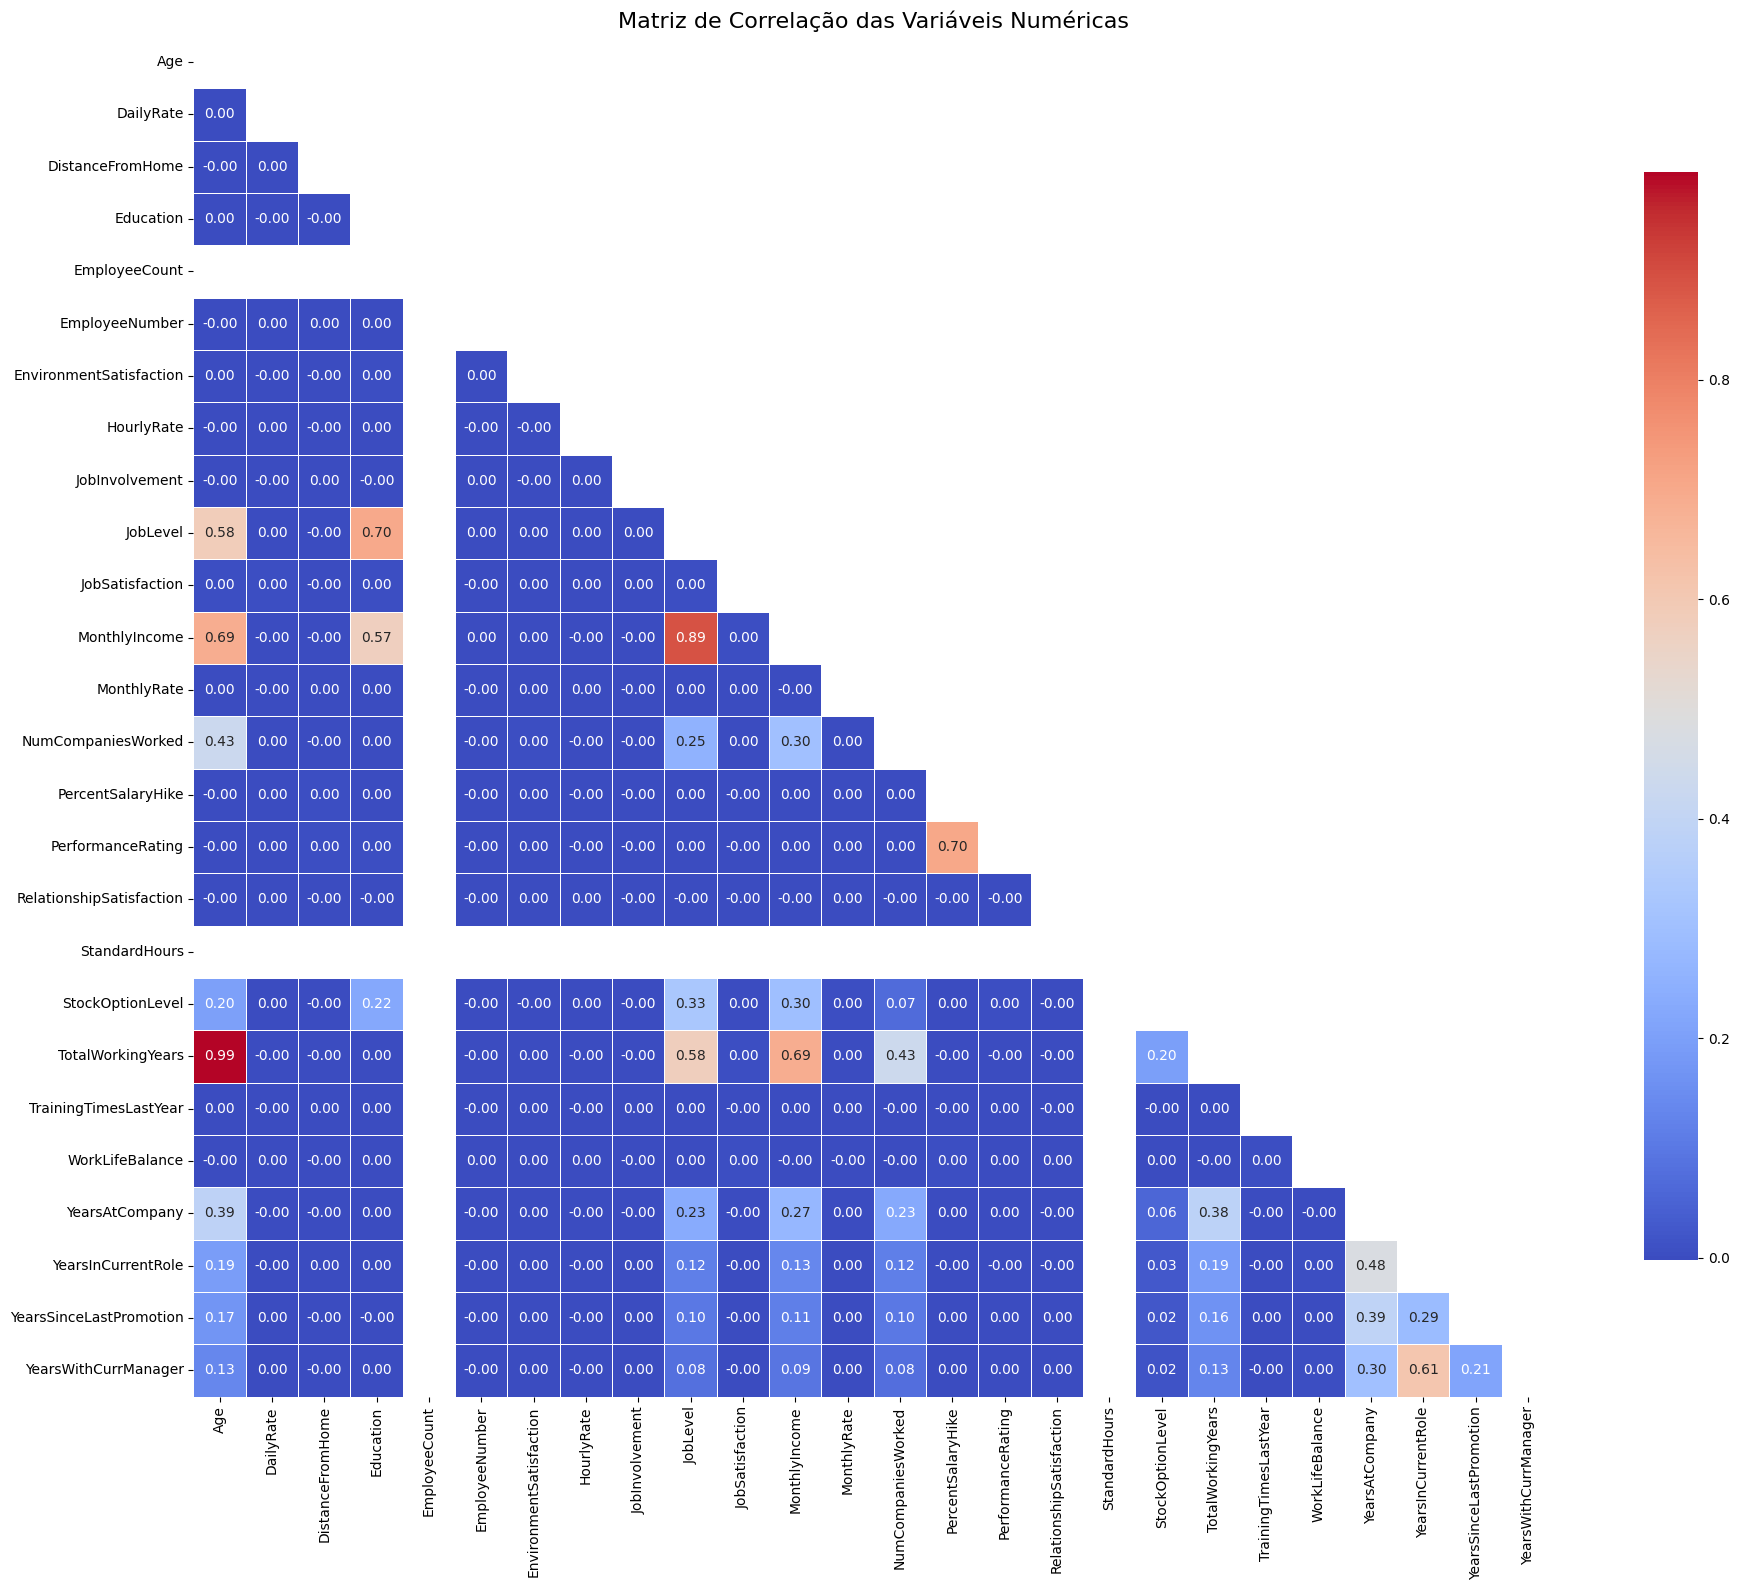

In [10]:
plt.figure(figsize=(20, 16))
correlation_matrix = df[numeric_cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title('Matriz de Correlação das Variáveis Numéricas', fontsize=16)
plt.tight_layout()
plt.show()

### Var categoricas

In [11]:
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

In [12]:
crosstab = pd.crosstab(df['DistanceFromHome'], df['Attrition'])
crosstab

Attrition,No,Yes
DistanceFromHome,,
1,109883,23540
2,94961,20438
3,82055,17501
4,71501,15192
5,62285,13117
6,54030,11490
7,46685,9965
8,39949,8715
9,34883,7583


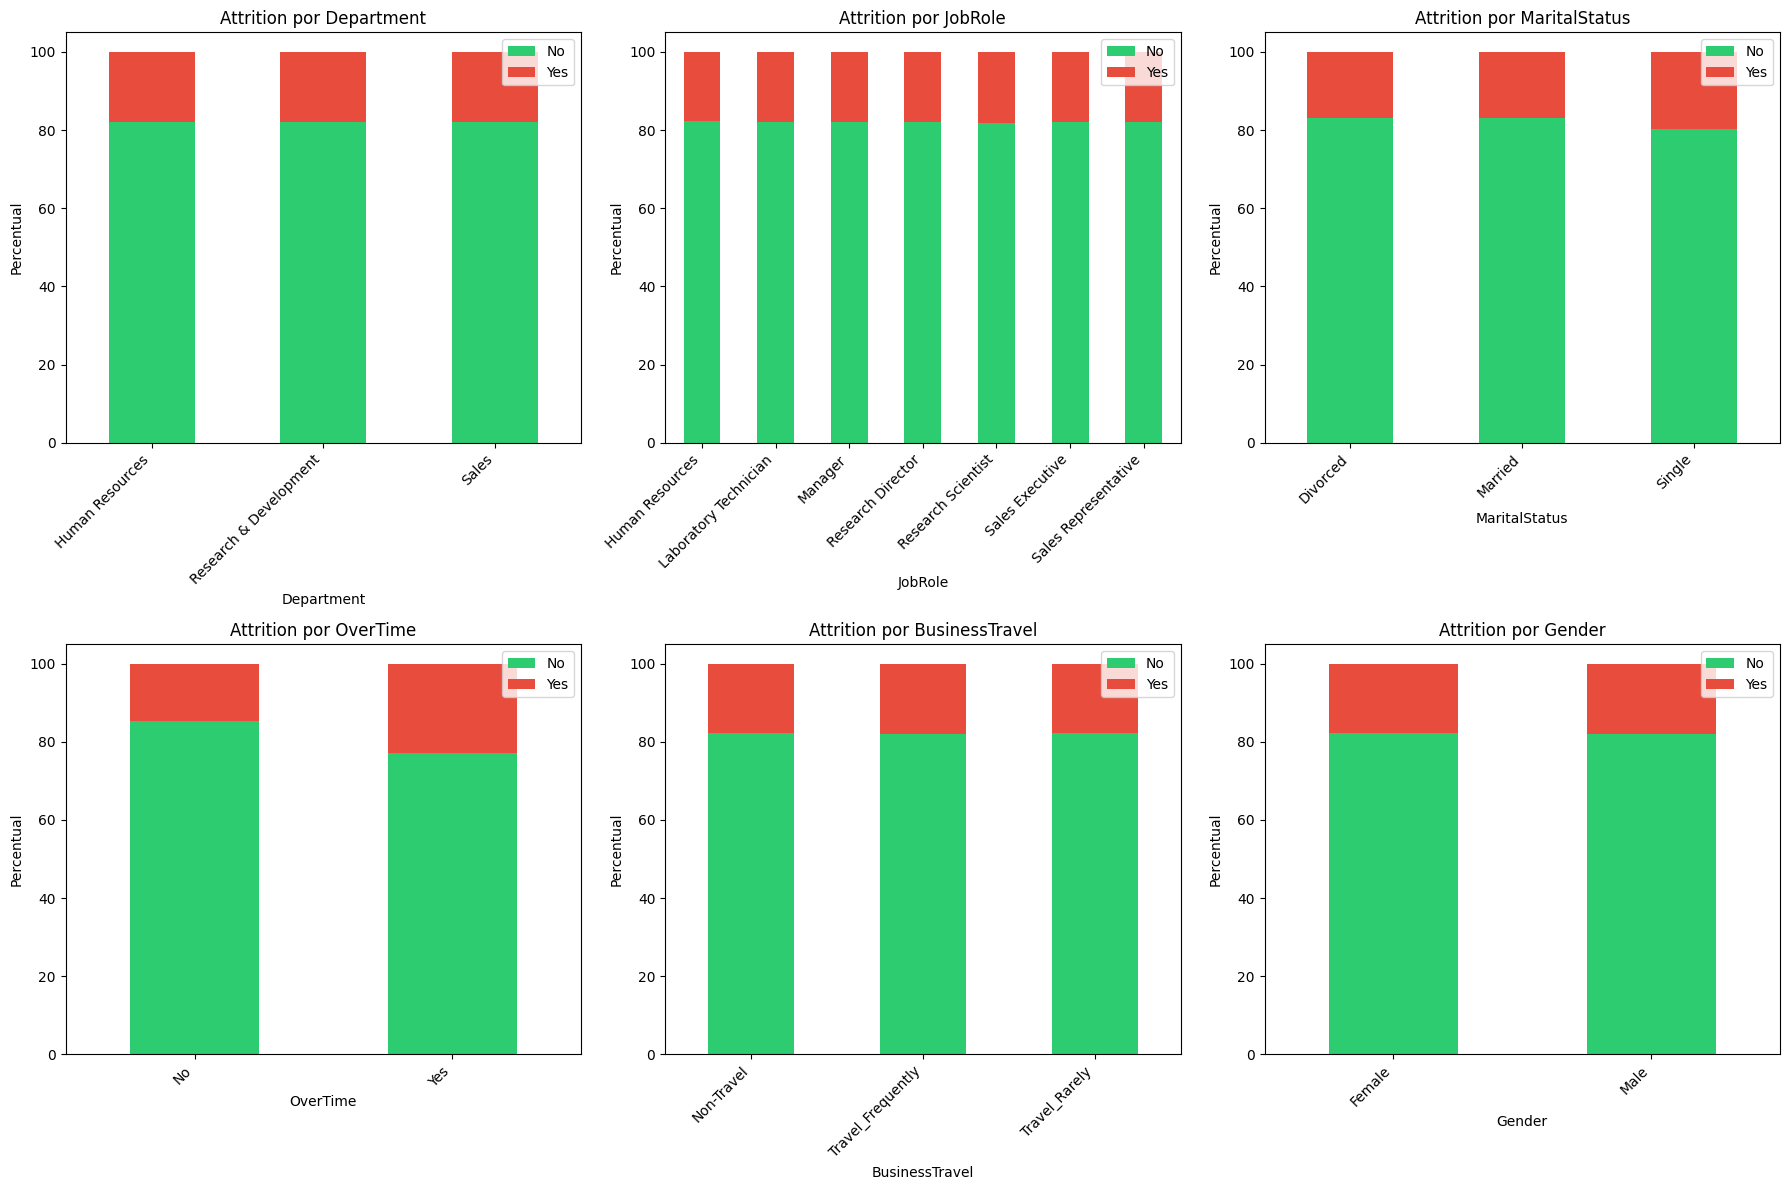

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

important_cats = ['Department', 'JobRole', 'MaritalStatus', 'OverTime', 'BusinessTravel', 'Gender']

for idx, col in enumerate(important_cats):
    crosstab = pd.crosstab(df[col], df['Attrition'])
    crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

    crosstab_pct.plot(kind='bar', ax=axes[idx], stacked=True, color=['#2ecc71', '#e74c3c'])
    axes[idx].set_title(f'Attrition por {col}')
    axes[idx].set_ylabel('Percentual')
    axes[idx].legend(['No', 'Yes'], loc='upper right')
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Distribuição de Idade, Salário, Anos na Empresa

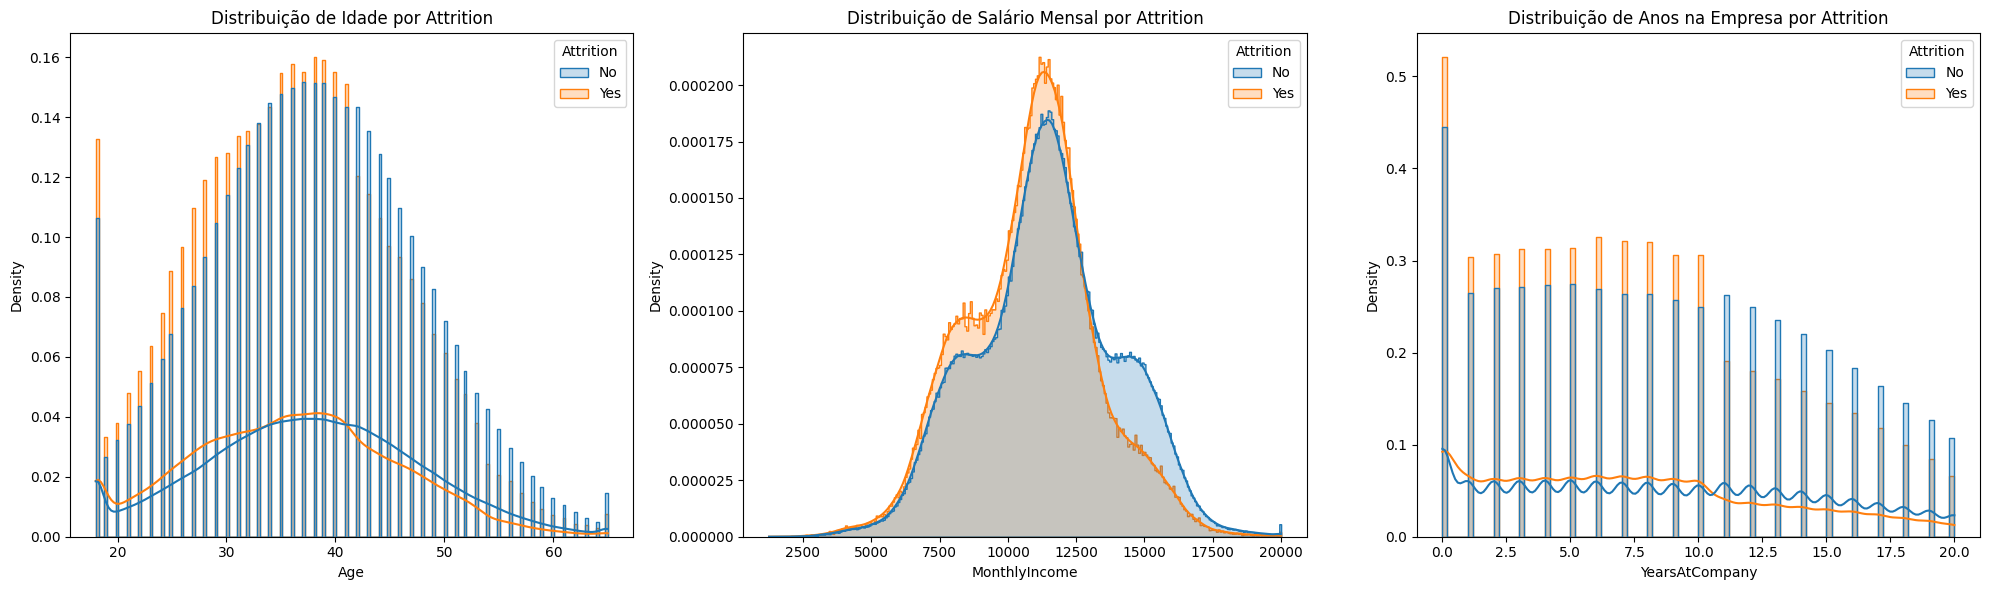

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.histplot(data=df, x="Age", hue="Attrition", kde=True, ax=axes[0], element="step", stat="density", common_norm=False)
axes[0].set_title('Distribuição de Idade por Attrition')

sns.histplot(data=df, x="MonthlyIncome", hue="Attrition", kde=True, ax=axes[1], element="step", stat="density", common_norm=False)
axes[1].set_title('Distribuição de Salário Mensal por Attrition')

sns.histplot(data=df, x="YearsAtCompany", hue="Attrition", kde=True, ax=axes[2], element="step", stat="density", common_norm=False)
axes[2].set_title('Distribuição de Anos na Empresa por Attrition')
plt.tight_layout()
plt.show()

### Boxplots de Salário, Idade, Distância

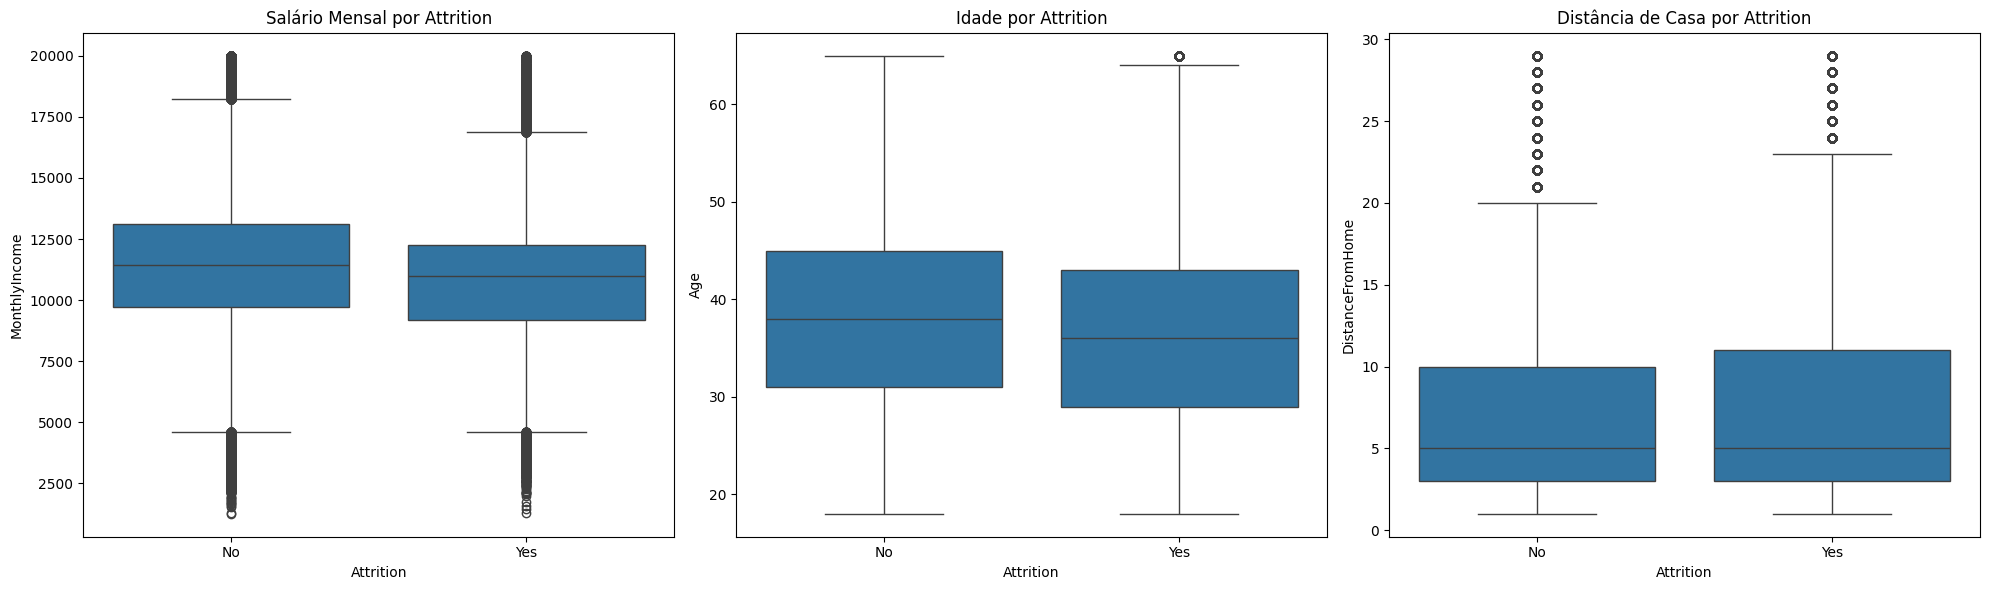

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.boxplot(data=df, x="Attrition", y="MonthlyIncome", ax=axes[0])
axes[0].set_title('Salário Mensal por Attrition')

sns.boxplot(data=df, x="Attrition", y="Age", ax=axes[1])
axes[1].set_title('Idade por Attrition')

sns.boxplot(data=df, x="Attrition", y="DistanceFromHome", ax=axes[2])
axes[2].set_title('Distância de Casa por Attrition')
plt.tight_layout()
plt.show()

### Attrition vs Satisfação

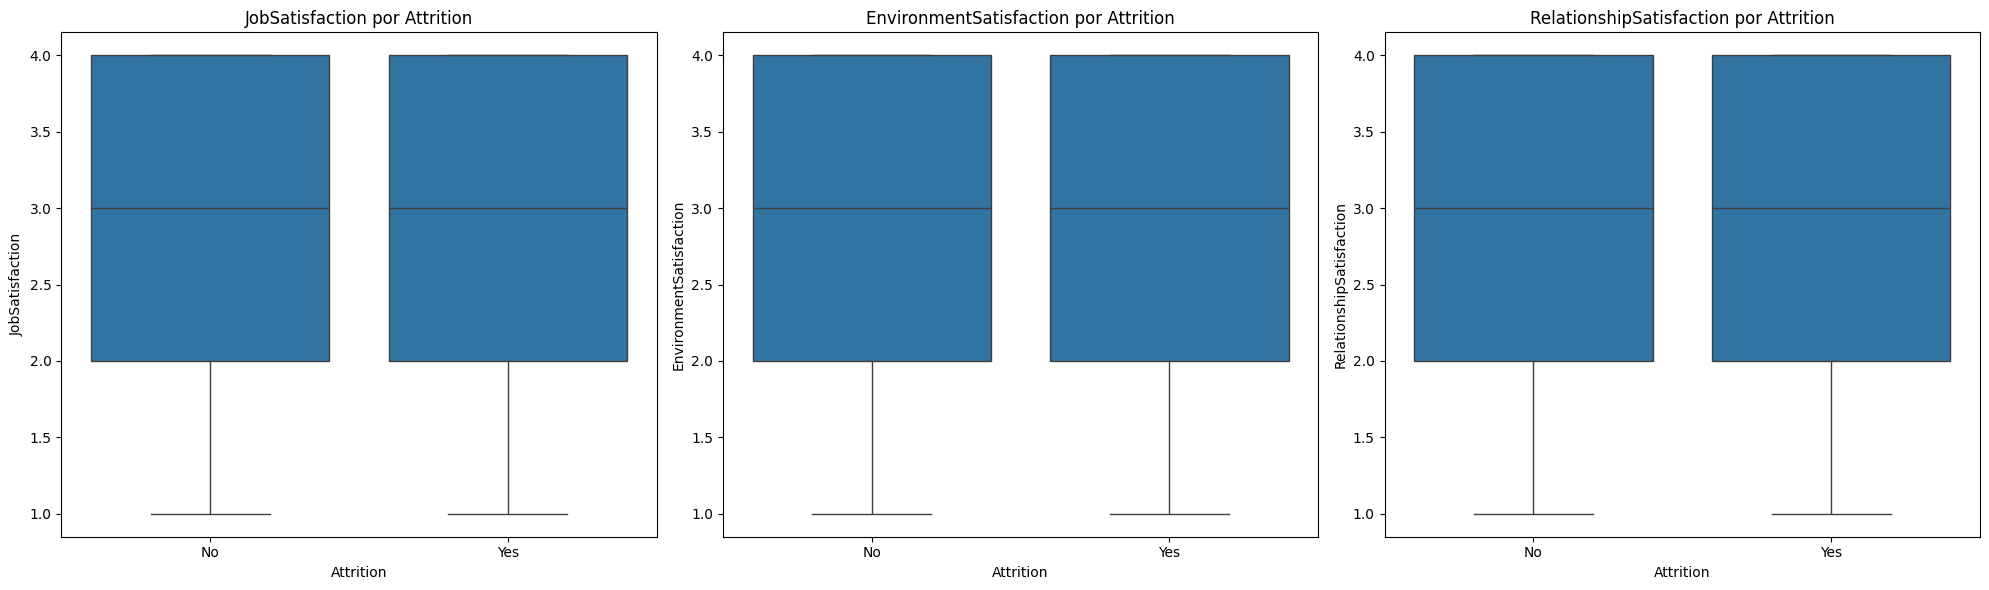

In [16]:
satisf_vars = ['JobSatisfaction', 'EnvironmentSatisfaction', 'RelationshipSatisfaction']
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, var in enumerate(satisf_vars):
    sns.boxplot(data=df, x="Attrition", y=var, ax=axes[i])
    axes[i].set_title(f'{var} por Attrition')
plt.tight_layout()
plt.show()

###  Matriz de Confusão de Features Categóricas (Department x OverTime)

/tmp/ipykernel_2373140/1974017600.py:1: FutureWarning: The provided callable <function mean at 0x7f98344403a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = pd.crosstab(df['Department'], df['OverTime'], values=(df['Attrition'] == 'Yes'), aggfunc=np.mean).fillna(0)


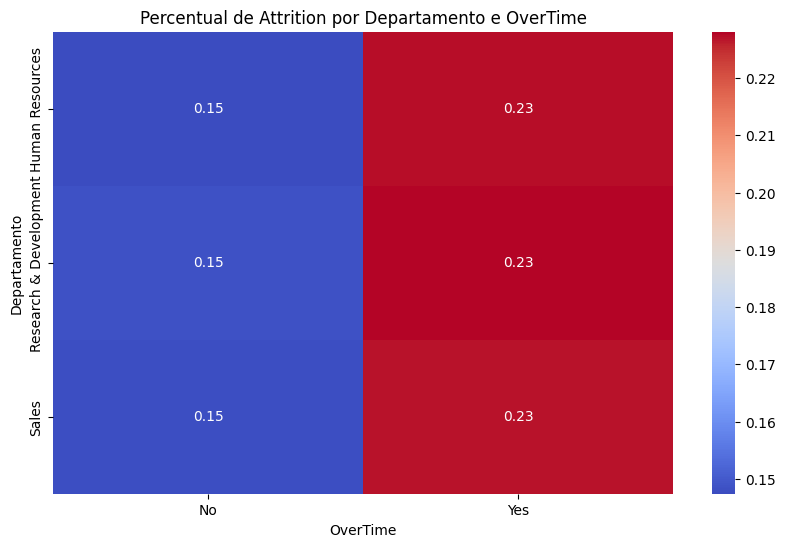

In [17]:
pivot = pd.crosstab(df['Department'], df['OverTime'], values=(df['Attrition'] == 'Yes'), aggfunc=np.mean).fillna(0)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Percentual de Attrition por Departamento e OverTime')
plt.ylabel('Departamento')
plt.xlabel('OverTime')
plt.show()

# Features professor

In [23]:
# Ratio de salário vs anos de experiência
df['IncomePerYear'] = df['MonthlyIncome'] / (df['TotalWorkingYears'] + 1)

# Satisfação total (média de todas as satisfações)
satisfaction_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction']
df['TotalSatisfaction'] = df[satisfaction_cols].mean(axis=1)

# Anos sem promoção em relação aos anos na empresa
df['PromotionRate'] = df['YearsSinceLastPromotion'] / (df['YearsAtCompany'] + 1)

# Indicador se trabalha há muito tempo sem promoção
df['LongTimeNoPromotion'] = (df['YearsSinceLastPromotion'] > 5).astype(int)

# Idade quando começou a trabalhar
df['AgeStartedWorking'] = df['Age'] - df['TotalWorkingYears']
df['AgeStartedWorking'] = df.loc[df['AgeStartedWorking'] > 14,'AgeStartedWorking']
# Número de anos em outras empresas
df['YearsInOtherCompanies'] = df['TotalWorkingYears'] - df['YearsAtCompany']

# Taxa de mudança de empresa
df['CompanyChangeRate'] = df['NumCompaniesWorked'] / (df['TotalWorkingYears'] + 1)

print(f"Novas features criadas:{['IncomePerYear', 'TotalSatisfaction', 'PromotionRate', 'LongTimeNoPromotion','AgeStartedWorking', 'YearsInOtherCompanies', 'CompanyChangeRate']}")


Novas features criadas:['IncomePerYear', 'TotalSatisfaction', 'PromotionRate', 'LongTimeNoPromotion', 'AgeStartedWorking', 'YearsInOtherCompanies', 'CompanyChangeRate']


# Features novas

## Anos no mesmo cargo sem promoção
    Pode descrever se a pessoa está estagnada no mesmo cargo.

In [24]:
df['AnosCargoSemPromocao'] = df['YearsInCurrentRole'] - df['YearsSinceLastPromotion']
# Corrigir negativos para zero
df['AnosCargoSemPromocao'] = df['AnosCargoSemPromocao'].clip(lower=0)
df['AnosCargoSemPromocao'].value_counts(normalize=True) * 100

AnosCargoSemPromocao
0     55.0790
1      9.2551
2      8.2962
3      7.2864
4      5.9109
5      4.6767
6      3.5853
7      2.6095
8      1.7789
9      1.0568
10     0.4652
Name: proportion, dtype: float64

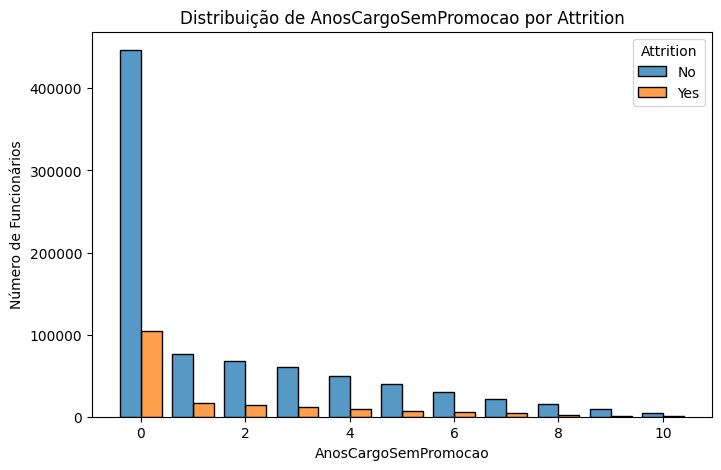

In [25]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="AnosCargoSemPromocao", hue="Attrition", multiple="dodge", shrink=0.8, discrete=True)
plt.title('Distribuição de AnosCargoSemPromocao por Attrition')
plt.xlabel('AnosCargoSemPromocao')
plt.ylabel('Número de Funcionários')
plt.show()

## Interação OverTime e JobLevel
    Funcionários em cargos altos que fazem muito OverTime podem estar sob risco diferente dos cargos mais baixos

In [26]:
df['CargoAlto_HorasExtras'] = ((df['JobLevel'] > 3) & (df['OverTime'] == 'Yes')).astype(int)
df['CargoAlto_HorasExtras'].value_counts(normalize=True) * 100

CargoAlto_HorasExtras
0    93.0041
1     6.9959
Name: proportion, dtype: float64

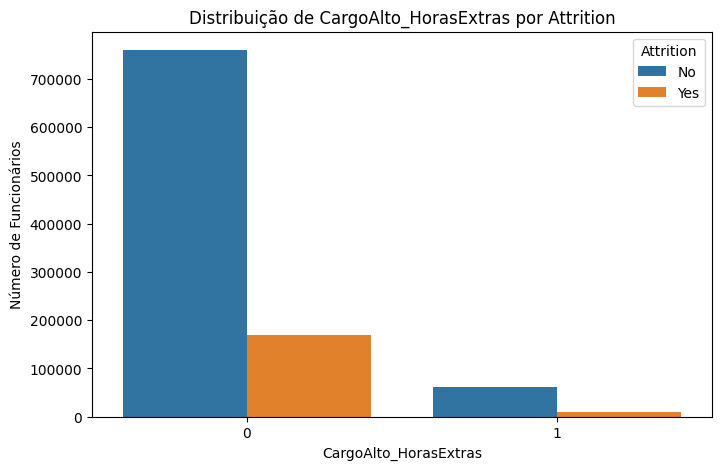

In [27]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="CargoAlto_HorasExtras", hue="Attrition")
plt.title('Distribuição de CargoAlto_HorasExtras por Attrition')
plt.xlabel('CargoAlto_HorasExtras')
plt.ylabel('Número de Funcionários')
plt.show()

## Score de estabilidade
    Pessoas que mudam muito de empresa tendem a sair mais


In [28]:
anos_de_carreira = df['Age'] - df['AgeStartedWorking'] + 1
df['ScoreEstab_Carreira'] = 1 / ( (df['NumCompaniesWorked'] / anos_de_carreira) + 1 )
df['ScoreEstab_Carreira'].value_counts(normalize=True) * 100

ScoreEstab_Carreira
1.000000    16.3321
0.750000     4.1417
0.800000     3.5280
0.833333     2.6376
0.500000     2.3435
             ...   
0.979167     0.0087
0.921569     0.0085
0.872727     0.0078
0.979592     0.0078
0.905660     0.0061
Name: proportion, Length: 228, dtype: float64

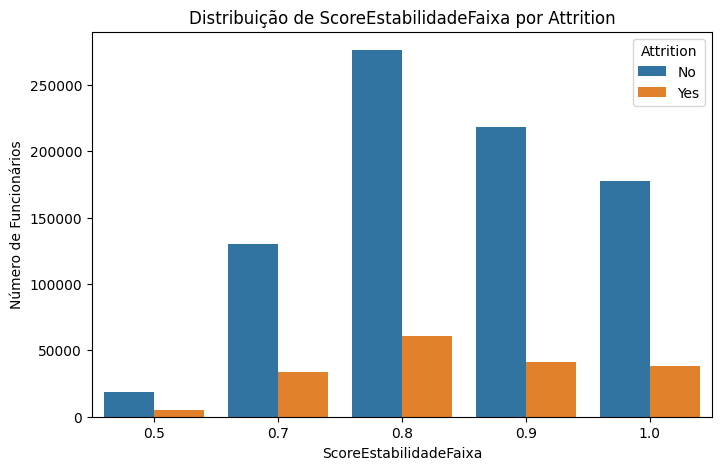

In [29]:
plt.figure(figsize=(8, 5))
df['ScoreEstabilidadeFormat'] = df['ScoreEstab_Carreira'].round(1)
sns.countplot(data=df, x="ScoreEstabilidadeFormat", hue="Attrition")
plt.title('Distribuição de ScoreEstabilidadeFaixa por Attrition')
plt.xlabel('ScoreEstabilidadeFaixa')
plt.ylabel('Número de Funcionários')
plt.show()

## burnout
    Quem tem alto OverTime, baixo WorkLifeBalance baixa satisfação como potencial burnout

In [30]:
df['Burnout'] = (
    (df['OverTime'] == 'Yes') &
    (df['WorkLifeBalance'] <= 2) &
    (df['TotalSatisfaction'] <= 2)
).astype(int)
df['Burnout'].value_counts(normalize=True) * 100

Burnout
0    98.6892
1     1.3108
Name: proportion, dtype: float64

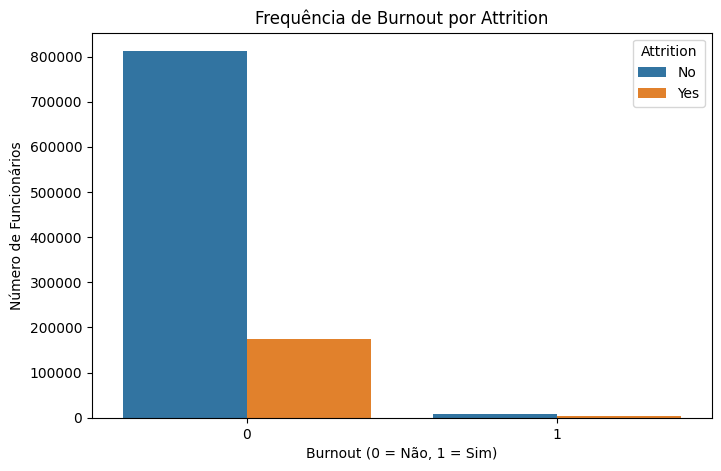

In [31]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Burnout", hue="Attrition")
plt.title('Frequência de Burnout por Attrition')
plt.xlabel('Burnout (0 = Não, 1 = Sim)')
plt.ylabel('Número de Funcionários')
plt.show()

# Features Luc

## Percentual de Anos na Empresa Atual

In [32]:
df['PercAnoEmpresaAtual'] = df['YearsAtCompany'] / (df['TotalWorkingYears'] + 1)
df['PercAnoEmpresaAtual']

0         0.200000
1         0.894737
2         0.869565
3         0.093750
4         0.777778
            ...   
999995    0.285714
999996    0.736842
999997    0.529412
999998    0.562500
999999    0.095238
Name: PercAnoEmpresaAtual, Length: 1000000, dtype: float64

## Salario por tempo de casa

In [33]:
df['SalarioPorTempodeCasa'] = df['MonthlyIncome']/(df['YearsAtCompany']+1)
df['SalarioPorTempodeCasa'] 

0         1896.666667
1          747.500000
2          662.761905
3         3050.250000
4          976.466667
             ...     
999995    1961.571429
999996     853.533333
999997    1201.100000
999998     713.210526
999999    3475.000000
Name: SalarioPorTempodeCasa, Length: 1000000, dtype: float64

## Treinamento por tempo de casa

In [34]:
df['TreinamentosPorTempodeCasa'] = df['TrainingTimesLastYear']/(df['YearsAtCompany']+1)
df['TreinamentosPorTempodeCasa']

0         0.500000
1         0.277778
2         0.142857
3         0.250000
4         0.133333
            ...   
999995    0.428571
999996    0.400000
999997    0.400000
999998    0.210526
999999    0.000000
Name: TreinamentosPorTempodeCasa, Length: 1000000, dtype: float64

## Tempo Cargo Atual Pelo Tempo Total trabalhado

In [35]:
df['TempoCargoAtualPeloNivel'] = df['YearsInCurrentRole']/ (df['TotalWorkingYears'] + 1)
df['TempoCargoAtualPeloNivel']

0         0.000000
1         0.421053
2         0.000000
3         0.093750
4         0.277778
            ...   
999995    0.190476
999996    0.526316
999997    0.117647
999998    0.000000
999999    0.095238
Name: TempoCargoAtualPeloNivel, Length: 1000000, dtype: float64

## Tempo Cargo Atual Pelo Nivel

In [36]:
df['TempoCargoAtualPeloNivel'] = df['YearsInCurrentRole']/ df['JobLevel']
df['TempoCargoAtualPeloNivel']

0         0.000000
1         2.666667
2         0.000000
3         1.000000
4         1.250000
            ...   
999995    1.000000
999996    3.333333
999997    0.666667
999998    0.000000
999999    0.666667
Name: TempoCargoAtualPeloNivel, Length: 1000000, dtype: float64

## Tempo Sem Promoção Por Tempo Com Manager

In [37]:
df['TempSemPromoPorTempComManager'] = df['YearsSinceLastPromotion']/(df['YearsWithCurrManager']+1)
df['TempSemPromoPorTempComManager']

0         3.000000
1         1.750000
2         1.000000
3         0.000000
4         0.500000
            ...   
999995    1.200000
999996    0.500000
999997    3.000000
999998    4.000000
999999    0.666667
Name: TempSemPromoPorTempComManager, Length: 1000000, dtype: float64

## Tempo com Gestor Atual em relação ao tempo na empresa

In [38]:
df['TempGestAtualPorTempodeCasa'] = df['YearsWithCurrManager']/ (df['YearsAtCompany']+1)
df['TempGestAtualPorTempodeCasa']

0         0.000000
1         0.166667
2         0.000000
3         0.750000
4         0.333333
            ...   
999995    0.571429
999996    0.200000
999997    0.100000
999998    0.000000
999999    0.666667
Name: TempGestAtualPorTempodeCasa, Length: 1000000, dtype: float64

## Salário por Quilômetro

In [39]:
df['SalarioPorKm'] = df['MonthlyIncome']/ (df['DistanceFromHome'])
df['SalarioPorKm']

0         11380.000000
1          6727.500000
2          6959.000000
3          1109.181818
4          2092.428571
              ...     
999995     1373.100000
999996      640.150000
999997      800.733333
999998     6775.500000
999999      359.482759
Name: SalarioPorKm, Length: 1000000, dtype: float64

## Salário por Nível de Educação 

In [40]:
df['SalarioPorNivelEdu'] = df['MonthlyIncome']/ (df['Education'])
df['SalarioPorNivelEdu']

0         3793.333333
1         3363.750000
2         3479.500000
3         6100.500000
4         2929.400000
             ...     
999995    3432.750000
999996    4267.666667
999997    3002.750000
999998    4517.000000
999999    3475.000000
Name: SalarioPorNivelEdu, Length: 1000000, dtype: float64

## Salário por SatisfaçãoMédia

In [41]:
df['SalarioPorSatisf'] = df['MonthlyIncome']/ (df['TotalSatisfaction'])
df['SalarioPorSatisf']

0         4877.142857
1         4036.500000
2         8350.800000
3         3660.300000
4         7323.500000
             ...     
999995    4577.000000
999996    4801.125000
999997    4003.666667
999998    5081.625000
999999    3475.000000
Name: SalarioPorSatisf, Length: 1000000, dtype: float64

# Features Vitor

## PromotionsPerYear
    Captura quão frequente são promoções — mais promoções em menos tempo, maior valor.

In [42]:
df['PromotionsPerYear'] = 1 / (df['YearsSinceLastPromotion'] + 1)
df['PromotionsPerYear']

0         0.250000
1         0.125000
2         0.500000
3         1.000000
4         0.250000
            ...   
999995    0.142857
999996    0.333333
999997    0.142857
999998    0.200000
999999    0.333333
Name: PromotionsPerYear, Length: 1000000, dtype: float64

## CompaniesPerYear
     Rotatividade externa: mais empresas em menos tempo.

In [43]:
df['CompaniesPerYear'] = df['NumCompaniesWorked'] / (df['TotalWorkingYears'] + 1)
df['CompaniesPerYear']

0         0.280000
1         0.368421
2         0.217391
3         0.187500
4         0.388889
            ...   
999995    0.000000
999996    0.210526
999997    0.235294
999998    0.125000
999999    0.000000
Name: CompaniesPerYear, Length: 1000000, dtype: float64

## YearsInRolePercCompany
     Indica se o colaborador está há muito tempo na mesma função.

In [44]:
df['YearsInRolePercCompany'] = df['YearsInCurrentRole'] / (df['YearsAtCompany'] + 1)
df['YearsInRolePercCompany']

0         0.000000
1         0.444444
2         0.000000
3         0.750000
4         0.333333
            ...   
999995    0.571429
999996    0.666667
999997    0.200000
999998    0.000000
999999    0.666667
Name: YearsInRolePercCompany, Length: 1000000, dtype: float64

## SatisfacaoGeral

In [45]:
df['SatisfacaoGeral'] = (
    df['JobSatisfaction'] +
    df['EnvironmentSatisfaction'] +
    df['RelationshipSatisfaction'] +
    df['JobInvolvement']
) / 4
df['SatisfacaoGeral']

0         2.50
1         3.25
2         1.75
3         3.50
4         1.75
          ... 
999995    3.25
999996    3.00
999997    3.00
999998    2.75
999999    2.50
Name: SatisfacaoGeral, Length: 1000000, dtype: float64

## SatisfacaoPeloNivel
     Indica se a satisfação acompanha a senioridade.

In [46]:
df['SatisfacaoPeloNivel'] = df['SatisfacaoGeral'] / df['JobLevel']
df['SatisfacaoPeloNivel']

0         0.833333
1         1.083333
2         0.437500
3         1.166667
4         0.437500
            ...   
999995    0.812500
999996    1.000000
999997    1.000000
999998    0.916667
999999    0.833333
Name: SatisfacaoPeloNivel, Length: 1000000, dtype: float64

## EstavelNaEmpresa
 1 para funcionários estáveis (muito tempo e pouca troca de empresa).

In [47]:
df['EstavelNaEmpresa'] = ((df['YearsAtCompany'] > 5) & (df['NumCompaniesWorked'] <= 2)).astype(int)
df['EstavelNaEmpresa']

0         0
1         0
2         0
3         0
4         0
         ..
999995    1
999996    0
999997    0
999998    0
999999    0
Name: EstavelNaEmpresa, Length: 1000000, dtype: int64

## TempoComGestorProporcao
    →Quanto tempo com o atual gestor em relação ao tempo de empresa.

In [48]:
df['TempoComGestorProporcao'] = df['YearsWithCurrManager'] / (df['YearsAtCompany'] + 1)
df['TempoComGestorProporcao']

0         0.000000
1         0.166667
2         0.000000
3         0.750000
4         0.333333
            ...   
999995    0.571429
999996    0.200000
999997    0.100000
999998    0.000000
999999    0.666667
Name: TempoComGestorProporcao, Length: 1000000, dtype: float64

## SalarioPorSatisfacaoGeral
     Salário alto nem sempre representa satisfação — ajuda a capturar desalinhamentos.

In [49]:
df['SalarioPorSatisfacaoGeral'] = df['MonthlyIncome'] / (df['SatisfacaoGeral'] + 1)
df['SalarioPorSatisfacaoGeral']

0         3251.428571
1         3165.882353
2         5061.090909
3         2711.333333
4         5326.181818
             ...     
999995    3230.823529
999996    3200.750000
999997    3002.750000
999998    3613.600000
999999    2978.571429
Name: SalarioPorSatisfacaoGeral, Length: 1000000, dtype: float64

## SalarioAjustadoPorCargo
     Serve para comparar discrepâncias salariais dentro do mesmo nível.

In [50]:
df['SalarioAjustadoPorCargo'] = df['MonthlyIncome'] / (df['JobLevel'] + 1)
df['SalarioAjustadoPorCargo']

0         2845.00
1         3363.75
2         2783.60
3         3050.25
4         2929.40
           ...   
999995    2746.20
999996    3200.75
999997    3002.75
999998    3387.75
999999    2606.25
Name: SalarioAjustadoPorCargo, Length: 1000000, dtype: float64

# EDA 2,0

In [51]:
numeric_cols2 = df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols2

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'IncomePerYear',
       'TotalSatisfaction', 'PromotionRate', 'LongTimeNoPromotion',
       'AgeStartedWorking', 'YearsInOtherCompanies', 'CompanyChangeRate',
       'AnosCargoSemPromocao', 'CargoAlto_HorasExtras', 'ScoreEstab_Carreira',
       'ScoreEstabilidadeFormat', 'Burnout', 'PercAnoEmpresaAtual',
       'SalarioPorTempodeCasa', 'TreinamentosPorTempodeCasa',
       'TempoCargoAtualPeloNivel', 'TempSemPromoPorTempComManager',
       'TempG

In [52]:
features_novas = list(set(numeric_cols2) - set(numeric_cols)-set(['IncomePerYear', 'TotalSatisfaction', 'PromotionRate', 'LongTimeNoPromotion','AgeStartedWorking', 'YearsInOtherCompanies', 'CompanyChangeRate']))
features_novas

['ScoreEstab_Carreira',
 'Burnout',
 'AnosCargoSemPromocao',
 'PercAnoEmpresaAtual',
 'SalarioPorNivelEdu',
 'SalarioPorTempodeCasa',
 'YearsInRolePercCompany',
 'SalarioAjustadoPorCargo',
 'SalarioPorKm',
 'SatisfacaoGeral',
 'EstavelNaEmpresa',
 'TempGestAtualPorTempodeCasa',
 'ScoreEstabilidadeFormat',
 'TreinamentosPorTempodeCasa',
 'CargoAlto_HorasExtras',
 'SatisfacaoPeloNivel',
 'TempSemPromoPorTempComManager',
 'SalarioPorSatisf',
 'PromotionsPerYear',
 'TempoComGestorProporcao',
 'CompaniesPerYear',
 'TempoCargoAtualPeloNivel',
 'SalarioPorSatisfacaoGeral']

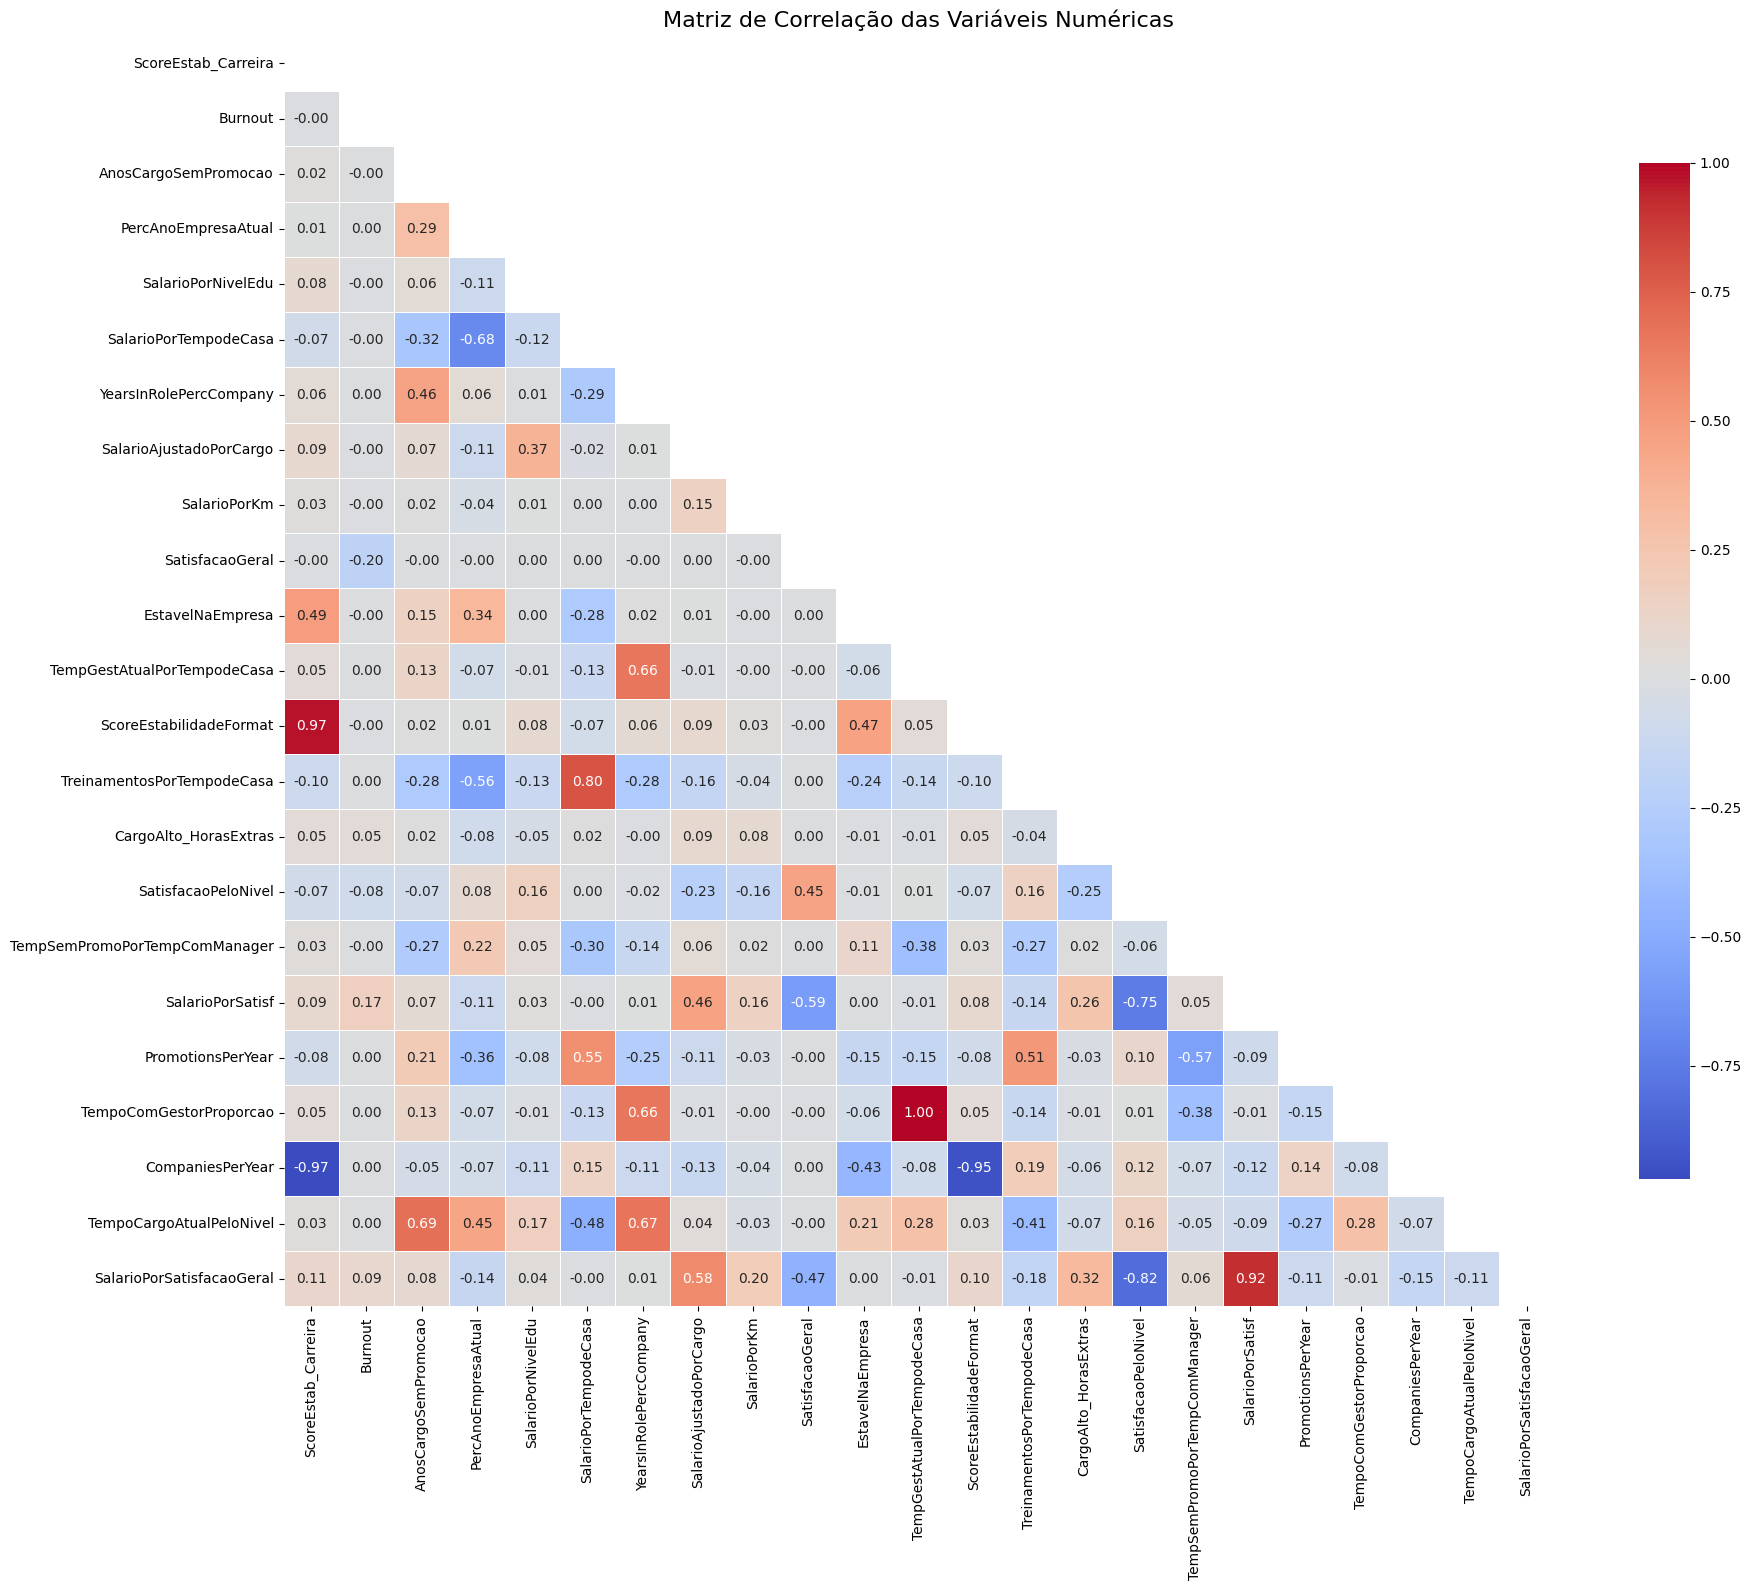

In [53]:
plt.figure(figsize=(20, 16))
correlation_matrix = df[features_novas].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title('Matriz de Correlação das Variáveis Numéricas', fontsize=16)
plt.tight_layout()
plt.show()

In [54]:
correlation_matrix

,ScoreEstab_Carreira,Burnout,AnosCargoSemPromocao,PercAnoEmpresaAtual,SalarioPorNivelEdu,SalarioPorTempodeCasa,YearsInRolePercCompany,SalarioAjustadoPorCargo,SalarioPorKm,SatisfacaoGeral,...,TreinamentosPorTempodeCasa,CargoAlto_HorasExtras,SatisfacaoPeloNivel,TempSemPromoPorTempComManager,SalarioPorSatisf,PromotionsPerYear,TempoComGestorProporcao,CompaniesPerYear,TempoCargoAtualPeloNivel,SalarioPorSatisfacaoGeral
ScoreEstab_Carreira,1.000000,-0.001213,0.024174,0.012923,0.081603,-0.070608,0.060520,0.091329,0.027017,-0.001289,...,-0.100544,0.047194,-0.074467,0.033324,0.088660,-0.076800,0.047993,-0.970470,0.028783,0.109670
Burnout,-0.001213,1.000000,-0.000483,0.004122,-0.002477,-0.001026,0.000887,-0.004302,-0.000986,-0.196515,...,0.000906,0.050254,-0.084853,-0.000333,0.173696,0.000062,0.000697,0.001776,0.002327,0.094801
AnosCargoSemPromocao,0.024174,-0.000483,1.000000,0.285292,0.060819,-0.315543,0.460004,0.073114,0.018578,-0.000175,...,-0.278716,0.022078,-0.073109,-0.271621,0.065000,0.208130,0.125870,-0.052041,0.686184,0.080811
PercAnoEmpresaAtual,0.012923,0.004122,0.285292,1.000000,-0.106064,-0.679243,0.057864,-0.107966,-0.036348,-0.000707,...,-0.560183,-0.078583,0.080066,0.223138,-0.111657,-0.356479,-0.065237,-0.068037,0.452941,-0.139672
SalarioPorNivelEdu,0.081603,-0.002477,0.060819,-0.106064,1.000000,-0.117356,0.006455,0.374431,0.009786,0.000358,...,-0.130242,-0.045035,0.162896,0.048588,0.030018,-0.083965,-0.012477,-0.113640,0.169524,0.036871
SalarioPorTempodeCasa,-0.070608,-0.001026,-0.315543,-0.679243,-0.117356,1.000000,-0.293095,-0.018966,0.000856,0.000851,...,0.797464,0.018203,0.004715,-0.304119,-0.002389,0.554569,-0.130151,0.145211,-0.484999,-0.002517
YearsInRolePercCompany,0.060520,0.000887,0.460004,0.057864,0.006455,-0.293095,1.000000,0.013942,0.001828,-0.000583,...,-0.280394,-0.004429,-0.015124,-0.136220,0.009338,-0.247040,0.661991,-0.108879,0.674719,0.011010
SalarioAjustadoPorCargo,0.091329,-0.004302,0.073114,-0.107966,0.374431,-0.018966,0.013942,1.000000,0.147677,0.000220,...,-0.161730,0.090829,-0.229256,0.060449,0.463078,-0.105299,-0.010012,-0.132169,0.040107,0.578006
SalarioPorKm,0.027017,-0.000986,0.018578,-0.036348,0.009786,0.000856,0.001828,0.147677,1.000000,-0.000957,...,-0.043318,0.081578,-0.159060,0.016151,0.156254,-0.029396,-0.003336,-0.037926,-0.029497,0.195186
SatisfacaoGeral,-0.001289,-0.196515,-0.000175,-0.000707,0.000358,0.000851,-0.000583,0.000220,-0.000957,1.000000,...,0.000133,0.000488,0.454318,0.000679,-0.593194,-0.000354,-0.000738,0.001446,-0.000393,-0.467407


In [55]:
corr_pairs = correlation_matrix.abs().where(~np.eye(correlation_matrix.shape[0], dtype=bool))
high_corr = corr_pairs.stack().reset_index()
high_corr.columns = ['Var1', 'Var2', 'Correlation']
high_corr = high_corr[high_corr['Correlation'] > 0.6].sort_values('Correlation', ascending=False)
high_corr

,Var1,Var2,Correlation
260,TempGestAtualPorTempodeCasa,TempoComGestorProporcao,1.000000
429,TempoComGestorProporcao,TempGestAtualPorTempodeCasa,1.000000
11,ScoreEstab_Carreira,ScoreEstabilidadeFormat,0.972904
264,ScoreEstabilidadeFormat,ScoreEstab_Carreira,0.972904
440,CompaniesPerYear,ScoreEstab_Carreira,0.970470
19,ScoreEstab_Carreira,CompaniesPerYear,0.970470
452,CompaniesPerYear,ScoreEstabilidadeFormat,0.945304
283,ScoreEstabilidadeFormat,CompaniesPerYear,0.945304
395,SalarioPorSatisf,SalarioPorSatisfacaoGeral,0.916931
501,SalarioPorSatisfacaoGeral,SalarioPorSatisf,0.916931


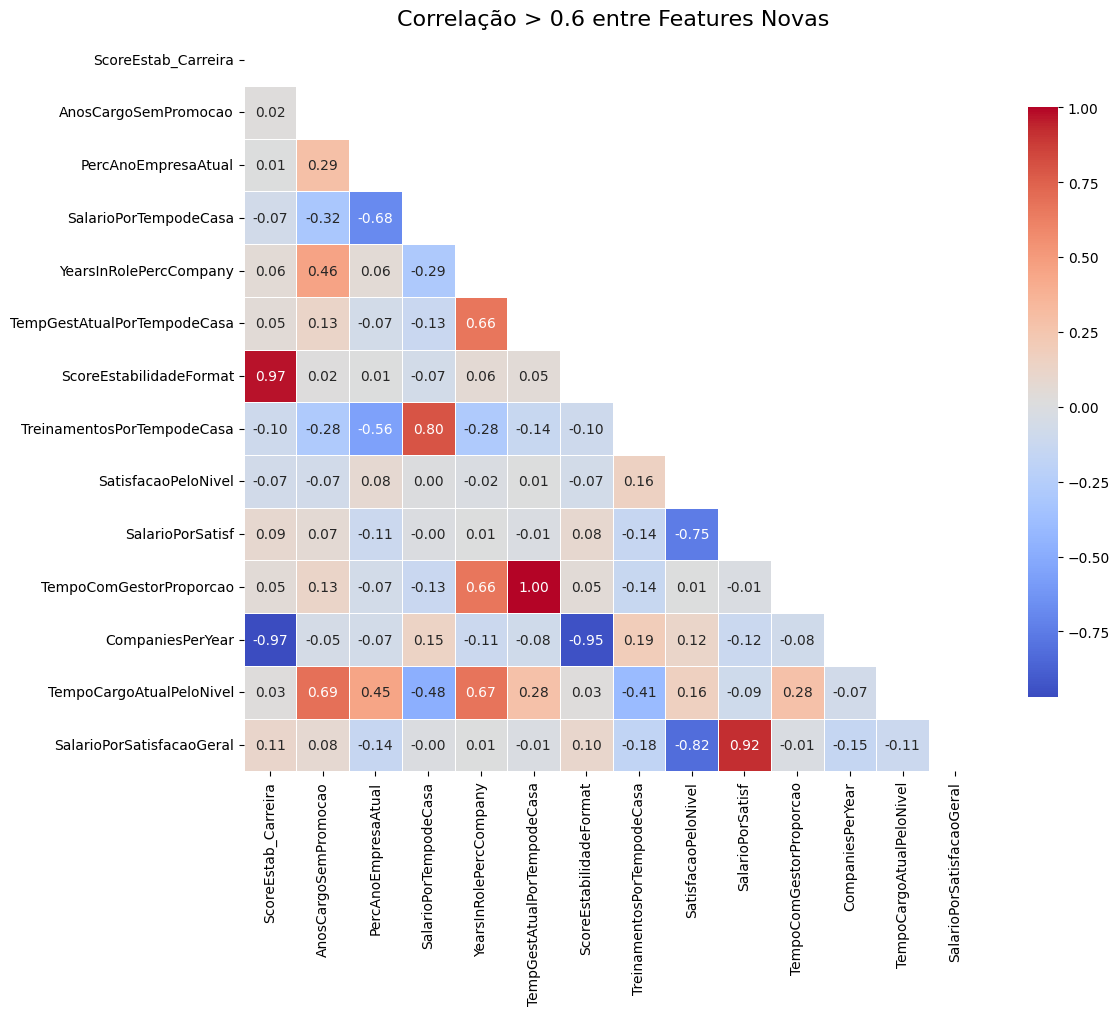

In [56]:
correlation_matrix = df[features_novas].corr().abs()

np.fill_diagonal(correlation_matrix.values, 0)
features_fortes = correlation_matrix.columns[(correlation_matrix > 0.6).any()].tolist()

correlation_matrix_filtrada = df[features_fortes].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix_filtrada, dtype=bool))
sns.heatmap(correlation_matrix_filtrada, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlação > 0.6 entre Features Novas', fontsize=16)
plt.tight_layout()
plt.show()
